In [1]:
# 以下是特別為了進行cross validation切割以及彙整所有CT資料使用，請視情況使用，無法直接run。
import glob, pandas as pd, os
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold

In [2]:
#取得路徑下所有資料
count=0
data_getcwd = '/ssd7/ICCV2025_COVID19/track1_fixed' #base path
full_data_list = [] #儲存所有slice清單
full_path_list = [] #儲存所有CT資料夾清單

for i in ['non-covid', 'covid']:
        for path in Path(os.path.join(data_getcwd, 'train', i)).rglob('*.jpg'): #尋找所有*jpg檔案
                ct_name = str(path.parent).split('/')[-1]
                label = 0 if 'non-covid' in str(path) else 1
                token_key = ct_name+'_0' if 'non-covid' in str(path) else ct_name+'_1'
                full_data_list.append([str(path.parent), ct_name, str(path.name), label, 0, token_key])
                full_path_list.append([str(path.parent), label, 0, token_key])


full_data_list = pd.DataFrame(full_data_list, columns=['path', 'ct_name', 'slice_name','label', 'fold', 'token_key']).reset_index(drop=True) #重置index用於篩選location
full_path_list = pd.DataFrame(full_path_list, columns=['parent_path', 'label', 'fold', 'token_key']).drop_duplicates(subset='parent_path').reset_index(drop=True) #重置index用於篩選location

In [3]:
full_path_list

,parent_path,label,fold,token_key
0,/ssd7/ICCV2025_COVID19/track1_fixed/train/non-...,0,0,ct_scan_652_0
1,/ssd7/ICCV2025_COVID19/track1_fixed/train/non-...,0,0,ct_scan_462_0
2,/ssd7/ICCV2025_COVID19/track1_fixed/train/non-...,0,0,ct_scan_76_0
3,/ssd7/ICCV2025_COVID19/track1_fixed/train/non-...,0,0,ct_scan_180_0
4,/ssd7/ICCV2025_COVID19/track1_fixed/train/non-...,0,0,ct_scan_278_0
...,...,...,...,...
1217,/ssd7/ICCV2025_COVID19/track1_fixed/train/covi...,1,0,ct_scan_156_1
1218,/ssd7/ICCV2025_COVID19/track1_fixed/train/covi...,1,0,ct_scan_384_1
1219,/ssd7/ICCV2025_COVID19/track1_fixed/train/covi...,1,0,ct_scan_539_1
1220,/ssd7/ICCV2025_COVID19/track1_fixed/train/covi...,1,0,ct_scan_268_1


In [4]:
df = pd.DataFrame(full_path_list)

# Extracting 'negative' or 'positive' from each 'parent_path'
df['category'] = df['parent_path'].apply(lambda x: 'non-covid' if 'non-covid' in x else 'covid')

# Counting the occurrences of each category
category_counts = df['category'].value_counts()
category_counts

category
non-covid    658
covid        564
Name: count, dtype: int64

In [5]:
drop_count_t = 0
filter_num = 20
for path_ in full_path_list['parent_path']:
    i = len(os.listdir(path_))
    if i <filter_num:
        print(f"張數{i}", path_)

張數13 /ssd7/ICCV2025_COVID19/track1_fixed/train/non-covid/ct_scan_300
張數5 /ssd7/ICCV2025_COVID19/track1_fixed/train/non-covid/ct_scan_299
張數5 /ssd7/ICCV2025_COVID19/track1_fixed/train/non-covid/ct_scan_214


張數13 /ssd7/ICCV2025_COVID19/track1_fixed/train/non-covid/ct_scan_300
張數5 /ssd7/ICCV2025_COVID19/track1_fixed/train/non-covid/ct_scan_299
張數5 /ssd7/ICCV2025_COVID19/track1_fixed/train/non-covid/ct_scan_214


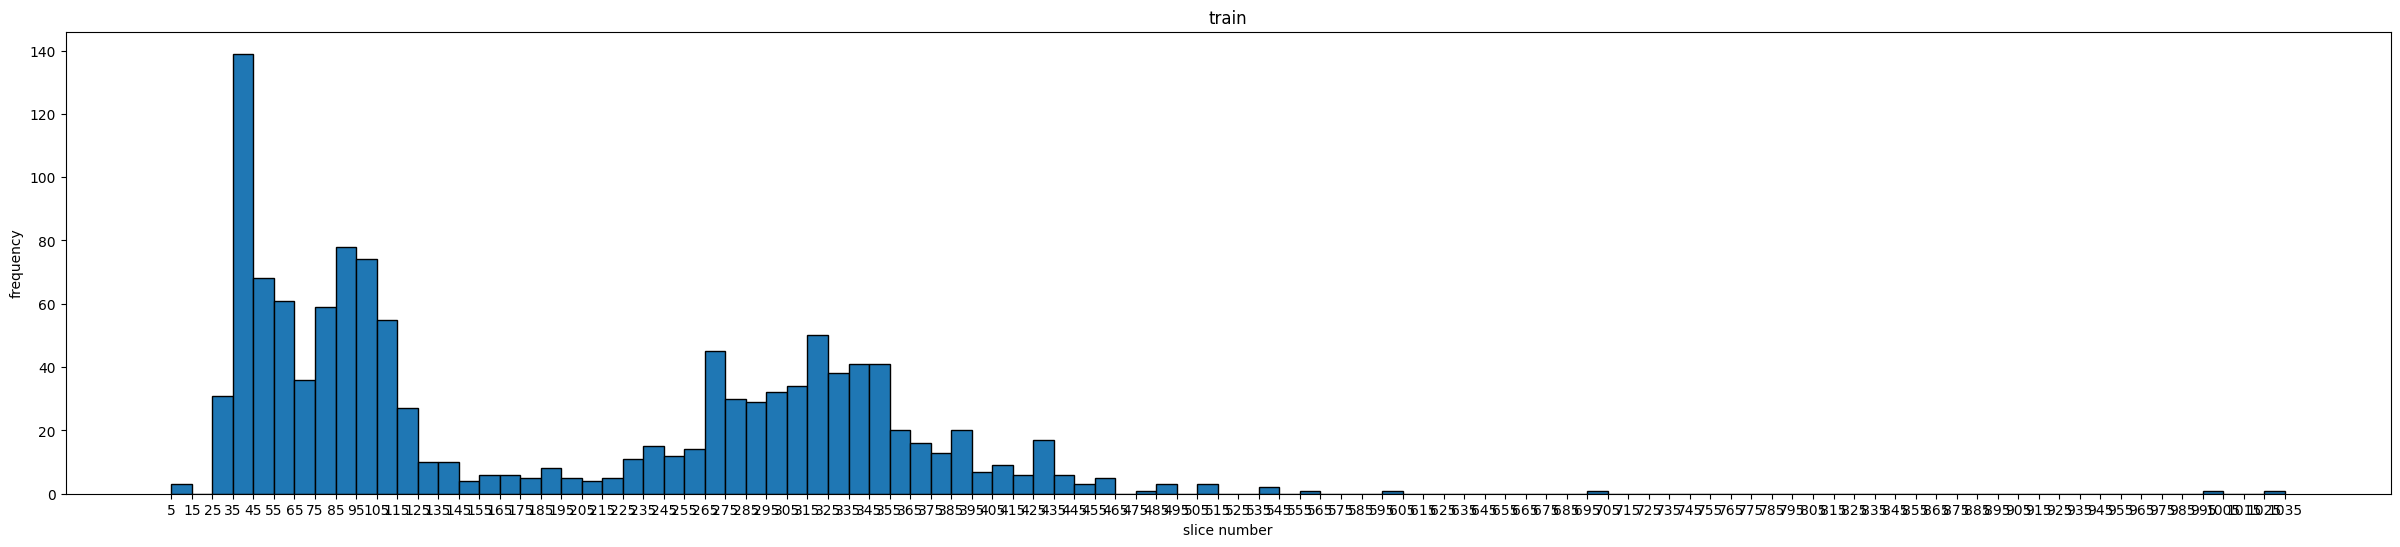

In [6]:
import os
import matplotlib.pyplot as plt

# 初始化张数列表
counts = []

# 遍历路径，计算每个目录中的文件数
for path_ in full_path_list['parent_path']:
    count = len(os.listdir(path_))
    counts.append(count)
    if count < filter_num:
        print(f"張數{count}", path_)

# 绘制直方图
bin_width = 10  # 或者20，根据需要调整
bins = range(min(counts), max(counts) + bin_width, bin_width)

# 绘制直方图
plt.figure(figsize=(30, 6))
plt.hist(counts, bins=bins, edgecolor='black')
plt.title('train')
plt.xlabel('slice number')
plt.ylabel('frequency')

# 设置X轴的标签
plt.xticks(bins)
plt.show()


In [7]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [8]:

for idx, (train, test) in enumerate(kfold.split(full_path_list['token_key'].values, full_path_list['label'].values)):#基於index設立fold number
    # print(test)
    full_path_list.loc[test, 'fold']=idx+1 #將挑選出來的fold index用於篩選CT資料夾清單的index資料，並且將fold欄位全覆蓋為當前的fold number

In [9]:
from tqdm import tqdm
for i in tqdm(range (len(full_path_list))): #根據CT資料夾清單對所有Slice進行fold欄位覆蓋
    ct_name = full_path_list.loc[i].token_key #取得CT資料夾名字
    row_index = full_data_list['token_key']==ct_name #取得所有Slice清單中符合當前CT資料夾名字的index
    fold = full_path_list.loc[i].fold #取得CT資料夾清單的fold數字
    full_data_list.loc[row_index,'fold'] = fold #將挑選出來的slice清單的fold數字，全部替換成CT資料夾清單挑選出來的fold數字

100%|██████████| 1222/1222 [00:33<00:00, 37.03it/s]


In [10]:
drop_valid_df_list_ = full_data_list.drop_duplicates(subset='token_key')
all_train_list =[drop_valid_df_list_[drop_valid_df_list_['label']==1].path.values.tolist(),
                 drop_valid_df_list_[drop_valid_df_list_['label']==0].path.values.tolist()]

In [11]:
for i in [1,2,3,4]:
    temp = full_data_list[full_data_list['fold']==i]
    folder = temp['token_key'].drop_duplicates()
    label = temp.drop_duplicates(subset='token_key').label
    print("Fold-{} CT number: {} || Slice Sample: {} || CT covid: {}; CT non-covid: {}".format(i, len(folder),len(temp), sum(label), len(label)-sum(label)))
# full_data_list_save = full_data_list[['path', 'ct_name', 'slice_name','label', 'fold']]
full_data_list_save = full_data_list
full_data_list_save.to_csv('/ssd7/ICCV2025_COVID19/processing/chih_4_fold_covid_train_df.csv', index=False, encoding='utf-8-sig')
# full_data_list_save.to_csv('./Train_Valid_dataset/chih_4_fold_covid_train_df.csv', index=False, encoding='utf-8-sig')


Fold-1 CT number: 306 || Slice Sample: 59350 || CT covid: 141; CT non-covid: 165
Fold-2 CT number: 306 || Slice Sample: 54534 || CT covid: 141; CT non-covid: 165
Fold-3 CT number: 305 || Slice Sample: 60389 || CT covid: 141; CT non-covid: 164
Fold-4 CT number: 305 || Slice Sample: 56012 || CT covid: 141; CT non-covid: 164


In [12]:

count=0
data_getcwd = '/ssd7/ICCV2025_COVID19/track1_fixed' #base path
full_data_list = [] #儲存所有slice清單
full_path_list = [] #儲存所有CT資料夾清單

for i in ['non-covid', 'covid']:
        for path in Path(os.path.join(data_getcwd, 'val', i)).rglob('*.jpg'): #尋找所有*jpg檔案
                ct_name = str(path.parent).split('/')[-1]
                label = 0 if 'non-covid' in str(path) else 1
                token_key = ct_name+'_0' if 'non-covid' in str(path) else ct_name+'_1'
                full_data_list.append([str(path.parent), ct_name, str(path.name), label, 0, token_key])
                full_path_list.append([str(path.parent), label, 0, token_key])


full_data_list = pd.DataFrame(full_data_list, columns=['path', 'ct_name', 'slice_name','label', 'fold', 'token_key']).reset_index(drop=True) #重置index用於篩選location
full_path_list = pd.DataFrame(full_path_list, columns=['parent_path', 'label', 'fold', 'token_key']).drop_duplicates(subset='parent_path').reset_index(drop=True) #重置index用於篩選location

In [13]:
df = pd.DataFrame(full_path_list)

# Extracting 'negative' or 'positive' from each 'parent_path'
df['category'] = df['parent_path'].apply(lambda x: 'non-covid' if 'non-covid' in x else 'covid')

# Counting the occurrences of each category
category_counts = df['category'].value_counts()
category_counts

category
non-covid    180
covid        128
Name: count, dtype: int64

張數12 /ssd7/ICCV2025_COVID19/track1_fixed/val/non-covid/ct_scan_62


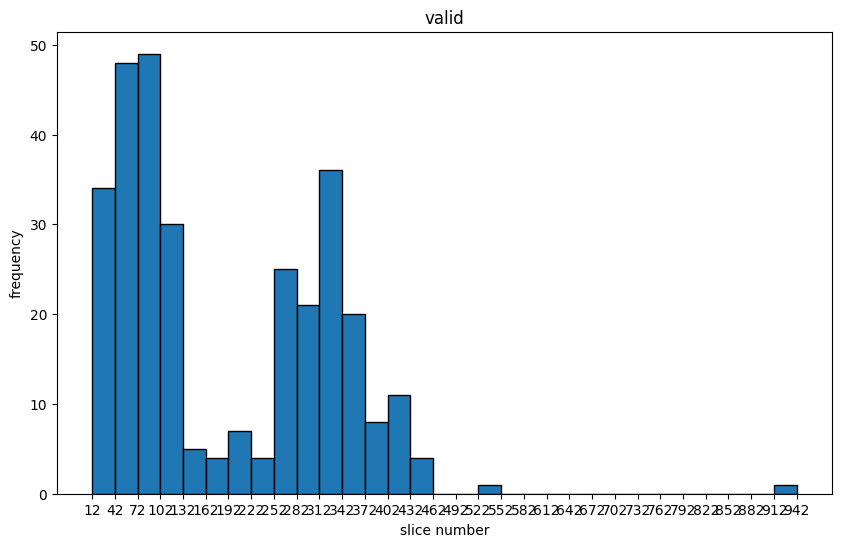

In [14]:
import os
import matplotlib.pyplot as plt

# 初始化张数列表
counts = []

# 遍历路径，计算每个目录中的文件数
for path_ in full_path_list['parent_path']:
    count = len(os.listdir(path_))
    counts.append(count)
    if count < filter_num:
        print(f"張數{count}", path_)

# 绘制直方图
bin_width = 30  # 或者20，根据需要调整
bins = range(min(counts), max(counts) + bin_width, bin_width)

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=bins, edgecolor='black')
plt.title('valid')
plt.xlabel('slice number')
plt.ylabel('frequency')

# 设置X轴的标签
plt.xticks(bins)

plt.show()


In [15]:
for i in [0]:
    temp = full_data_list[full_data_list['fold']==i]
    folder = temp['token_key'].drop_duplicates()
    label = temp.drop_duplicates(subset='token_key').label
    print("Fold-{} CT number: {} || Slice Sample: {} || CT covid: {}; CT non-covid: {}".format(i, len(folder),len(temp), sum(label), len(label)-sum(label)))
# full_data_list_save = full_data_list[['path', 'ct_name', 'slice_name','label', 'fold']]
full_data_list_save = full_data_list
full_data_list_save.to_csv('/ssd7/ICCV2025_COVID19/processing/chih_4_fold_covid_valid_df.csv', index=False, encoding='utf-8-sig')
# full_data_list_save.to_csv('./Train_Valid_dataset/chih_4_fold_covid_train_df.csv', index=False, encoding='utf-8-sig')


Fold-0 CT number: 308 || Slice Sample: 57714 || CT covid: 128; CT non-covid: 180


In [16]:
full_data_list_save['fold']=5
full_data_list_save

,path,ct_name,slice_name,label,fold,token_key
0,/ssd7/ICCV2025_COVID19/track1_fixed/val/non-co...,ct_scan_76,6.jpg,0,5,ct_scan_76_0
1,/ssd7/ICCV2025_COVID19/track1_fixed/val/non-co...,ct_scan_76,7.jpg,0,5,ct_scan_76_0
2,/ssd7/ICCV2025_COVID19/track1_fixed/val/non-co...,ct_scan_76,24.jpg,0,5,ct_scan_76_0
3,/ssd7/ICCV2025_COVID19/track1_fixed/val/non-co...,ct_scan_76,23.jpg,0,5,ct_scan_76_0
4,/ssd7/ICCV2025_COVID19/track1_fixed/val/non-co...,ct_scan_76,13.jpg,0,5,ct_scan_76_0
...,...,...,...,...,...,...
57709,/ssd7/ICCV2025_COVID19/track1_fixed/val/covid/...,ct_scan_14,147.jpg,1,5,ct_scan_14_1
57710,/ssd7/ICCV2025_COVID19/track1_fixed/val/covid/...,ct_scan_14,306.jpg,1,5,ct_scan_14_1
57711,/ssd7/ICCV2025_COVID19/track1_fixed/val/covid/...,ct_scan_14,106.jpg,1,5,ct_scan_14_1
57712,/ssd7/ICCV2025_COVID19/track1_fixed/val/covid/...,ct_scan_14,15.jpg,1,5,ct_scan_14_1


In [17]:
full_data_list_save.to_csv('/ssd7/ICCV2025_COVID19/processing/chih_4_fold_covid_valid_df.csv', index=False, encoding='utf-8-sig')

In [18]:
import pandas as pd
train=pd.read_csv('/ssd7/ICCV2025_COVID19/processing/chih_4_fold_covid_train_df.csv')
val=pd.read_csv('/ssd7/ICCV2025_COVID19/processing/chih_4_fold_covid_valid_df.csv')
full=pd.concat([train,val],axis=0)
full.to_csv('/ssd7/ICCV2025_COVID19/processing/chih_full_df.csv', index=False, encoding='utf-8-sig')
full['path']=full['path'].apply(lambda x: x.replace('train', 'train_pure_crop_challenge') if 'train' in x else x)
full['path']=full['path'].apply(lambda x: x.replace('val', 'valid_pure_crop_challenge') if 'val' in x else x)
full.to_csv('/ssd7/ICCV2025_COVID19/processing/chih_full_replaced_df.csv', index=False, encoding='utf-8-sig')